In [ ]:
api_key =   #replace it with openAI api key
load_trained_data = 1
run_openAI_experiments = 1-load_trained_data
# load_prompts_from_Git = 1
# run_openAI_experiments = 0  #openAI experiments
# load_RecLLMparsed_df = load_prompts_from_Git
# load_RecLLMparsed_with_itemIds = load_prompts_from_Git

In [ ]:
!pip install openai==0.28.0
!pip install --upgrade nltk
import openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


## Utility Functions

In [ ]:
import numpy as np
import pandas as pd
def print_statistics(data):
    total_interactions = data.shape[0]
    unique_users = data['userId'].nunique()
    unique_items = data['itemId'].nunique()

    print("--------------------------")
    print("The Dataset Overview:")
    print(f" - Total Interactions: {total_interactions}")
    print(f" - |U|: {unique_users}")
    print(f" - |I|: {unique_items}")
    print(f" - |R|/|U|: {total_interactions / unique_users:.2f}")
    print(f" - |R|/|I|: {total_interactions / unique_items:.2f}")
    print(f" - |R|/(|U|*|I|): {total_interactions / (unique_users * unique_items):.10f}")
    print("--------------------------")
# print_statistics(train_df)
# print_statistics(test_df)


def sample_users(df_ratings, num_users):
    # Get a list of unique users
    unique_users = df_ratings['userId'].unique()

    # Sample a specified number of users
    sampled_users = pd.Series(unique_users).sample(n=num_users, random_state=42)

    # Get all ratings for the sampled users
    df_sampled_ratings = df_ratings[df_ratings['userId'].isin(sampled_users)]

    return df_sampled_ratings


def apply_interaction_limits(data, min_interactions, max_interactions, user_col, item_col):
    # Count the number of interactions by user
    interaction_counts = data[user_col].value_counts()

    # Filter out users outside the interaction limits
    users_to_keep = interaction_counts[(interaction_counts >= min_interactions) & (interaction_counts <= max_interactions)].index
    return data[data[user_col].isin(users_to_keep)]


def analyze_tags(df_item):
    # Count unique item IDs
    unique_item_ids = df_item['itemId'].nunique()

    # Count unique tags across all items (flattening the lists first)
    unique_tags = set(tag for sublist in df_item['tag'] for tag in sublist)
    unique_tags_count = len(unique_tags)

    # Count how many items have at least one tag
    items_with_tags = df_item[df_item['tag'].apply(lambda tags: len(tags) > 0)].shape[0]

    # Count how many items have no tags
    total_items = df_item.shape[0]
    items_without_tags = total_items - items_with_tags

    # Normalize to the entire number of items to get percentages
    items_with_tags_percentage = (items_with_tags / total_items) * 100
    items_without_tags_percentage = (items_without_tags / total_items) * 100

    # Print the results
    print(f"Total unique items (itemId): {unique_item_ids}")
    print(f"Total unique tags: {unique_tags_count}")
    print(f"Items with at least one tag: {items_with_tags} ({items_with_tags_percentage:.2f}%)")
    print(f"Items with no tags: {items_without_tags} ({items_without_tags_percentage:.2f}%)")


def check_column_for_nan(df, column_name):
    """
    Checks if a column in a DataFrame, identified by its name, contains NaN values.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.
    column_name (str): The name of the column to check for NaN values.

    Returns:
    int: 1 if NaN values are found, 0 if no NaN values are present.
    """
    # Ensure the column_name exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Return 1 if NaN values are found, otherwise return 0
    return int(df[column_name].isna().any())


# Introduce a NaN value in the 'tags' column
data = {
    'title': ['Movie A', 'Movie B', 'Movie C'],
    'genres': ['Action', 'Drama', 'Comedy'],
    'tags': ['Tag1', np.nan, 'Tag3']  # Introducing NaN in the 'tags' column
}

df = pd.DataFrame(data)
display(df)
# Check if the 'tags' column has NaN values
result = check_column_for_nan(df, 'tags')
print(f"'tags' column has NaN values: {result}")

# Check if the 'title' column has NaN values
result = check_column_for_nan(df, 'title')
print(f"'title' column has NaN values: {result}")


,title,genres,tags
0,Movie A,Action,Tag1
1,Movie B,Drama,NaN
2,Movie C,Comedy,Tag3


'tags' column has NaN values: 1
'title' column has NaN values: 0


#Download datasets

In [ ]:
import requests
import pandas as pd

def download_csv(url, csv_file_name):
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        with open(csv_file_name, "wb") as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"{csv_file_name} downloaded successfully.")
        return True
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
        return False

def load_datasets():
    # URLs for the ratings, items, and users datasets
    urlRatings = "https://raw.githubusercontent.com/yasdel/RecSys_Datasets/e3a18487525d3ae8ec19b39959c1a881c383e1a8/ml_latest/df_ratings_ml-latest-small.csv"
    urlItems = "https://raw.githubusercontent.com/yasdel/RecSys_Datasets/e3a18487525d3ae8ec19b39959c1a881c383e1a8/ml_latest/df_item_ml-latest-small.csv"
    urlTags = "https://raw.githubusercontent.com/yasdel/RecSys_Datasets/21484da12f01263fc0194d12c63d796628f84137/ml_latest/df_tags_ml-latest-small.csv"

    # Local filenames
    ratings_file = "df_ratings_ml-latest-small.csv"
    items_file = "df_item_ml-latest-small.csv"
    tags_file = "df_tags_ml-latest-small.csv"

    # Download the ratings, items, and users files
    if download_csv(urlRatings, ratings_file) and download_csv(urlItems, items_file) and download_csv(urlTags, tags_file):
        column_name = ['userId', 'itemId', 'rating', 'timestamp']
        df_ratings = pd.read_csv(ratings_file, sep=',', low_memory=False, header= 0 , names=column_name)
        df_items = pd.read_csv(items_file, sep=',', low_memory=False)
        df_tags = pd.read_csv(tags_file, sep=',', low_memory=False)
        df_ratings['userId'] = df_ratings['userId'].astype(int)
        df_ratings['itemId'] = df_ratings['itemId'].astype(int)
        df_items['itemId'] = df_items['itemId'].astype(int)
        df_tags['itemId'] = df_tags['itemId'].astype(int)
        df_tags['userId'] = df_tags['userId'].astype(int)

        # Group the tags by itemId and aggregate them into a list
        tags_grouped = df_tags.groupby('itemId')['tag'].apply(list).reset_index()

        # Merge the tags with the df_item to create a new column 'tags'
        df_items_merged = pd.merge(df_items, tags_grouped, on='itemId', how='left')

        # If there are items without tags, they will have NaN in the 'tags' column; replace with an empty list
        df_items_merged['tag'] = df_items_merged['tag'].apply(lambda x: x if isinstance(x, list) else [])

        print("ml-latest-small Datasets and tags loaded successfully.")
        print("Datasets loaded successfully.")
        return df_ratings, df_items,  df_tags, df_items_merged
    else:
        print("Failed to download one or more datasets.")
        return None, None, None

DS_name = "ml-latest-small"
# Usage example for ml-latest-small ratings, items, and users datasets
df_ratings, df_items, df_tags, df_items_merged = load_datasets()

print_statistics(df_ratings)
#sample_percentage = 0.3
#df_ratings_sampled = df_ratings.sample(frac=sample_percentage, random_state=42)
#print_statistics(df_ratings_sampled)


# Constants for interaction thresholds
MIN_INTERACTIONS_PER_USER = 20  # Minimum threshold for user activity
MAX_INTERACTIONS_PER_USER = 100  # Maximum threshold to exclude superusers

#Apply interaction limits
df_ratings_sampled = apply_interaction_limits(
     df_ratings,
     MIN_INTERACTIONS_PER_USER,
     MAX_INTERACTIONS_PER_USER,
     'userId',
     'itemId'
)

# limited_interaction_data
print_statistics(df_ratings_sampled)

# Specify the number of users to sample
#num_users = 200  # Change this to 200 or any other number if needed
#df_ratings_sampled = sample_users(limited_interaction_data, num_users)
#print(f"Sampled dataset.")
#print_statistics(df_ratings_sampled)


#this is used later forprint to output
other_info = f'filtering_min_{MIN_INTERACTIONS_PER_USER}_max_{MAX_INTERACTIONS_PER_USER}'
#other_info = f'no_filtering'


df_ratings_ml-latest-small.csv downloaded successfully.
df_item_ml-latest-small.csv downloaded successfully.
df_tags_ml-latest-small.csv downloaded successfully.
ml-latest-small Datasets and tags loaded successfully.
Datasets loaded successfully.
--------------------------
The Dataset Overview:
 - Total Interactions: 100836
 - |U|: 610
 - |I|: 9724
 - |R|/|U|: 165.30
 - |R|/|I|: 10.37
 - |R|/(|U|*|I|): 0.0169996831
--------------------------
--------------------------
The Dataset Overview:
 - Total Interactions: 16823
 - |U|: 365
 - |I|: 3079
 - |R|/|U|: 46.09
 - |R|/|I|: 5.46
 - |R|/(|U|*|I|): 0.0149692793
--------------------------


In [ ]:
# Get the unique users and items from the sampled interactions
sampled_user_ids = df_ratings_sampled['userId'].drop_duplicates()
sampled_item_ids = df_ratings_sampled['itemId'].drop_duplicates()

df_items_sampled = df_items[df_items['itemId'].isin(sampled_item_ids)]
df_items_merged_sampled = df_items_merged[df_items_merged['itemId'].isin(sampled_item_ids)]
df_items_merged_sampled

,itemId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[pixar, pixar, fun]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[fantasy, magic board game, Robin Williams, game]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[moldy, old]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,[]
4,5,Father of the Bride Part II (1995),Comedy,"[pregnancy, remake]"
...,...,...,...,...
9726,190209,Jeff Ross Roasts the Border (2017),Comedy,[]
9727,190213,John From (2015),Drama,[]
9728,190215,Liquid Truth (2017),Drama,[]
9729,190219,Bunny (1998),Animation,[]


In [ ]:
analyze_tags(df_items_merged_sampled)


# Display the sampled datasets
print("Sampled Interactions (Rating Matrix):")
display(df_ratings_sampled.head(10))

print("Sampled Item Dataset:")
display(df_items_sampled.head(100))

print("Sampled Merged Dataset:")
display(df_items_merged_sampled.head(100))

# Check if the 'tags' column has NaN values
result = check_column_for_nan(df_items_merged_sampled, 'itemId')
print(f"'itemId' column has NaN values: {result}")

Total unique items (itemId): 3079
Total unique tags: 1287
Items with at least one tag: 967 (31.41%)
Items with no tags: 2112 (68.59%)
Sampled Interactions (Rating Matrix):


,userId,itemId,rating,timestamp
232,2,318,3.0,1445714835
233,2,333,4.0,1445715029
234,2,1704,4.5,1445715228
235,2,3578,4.0,1445714885
236,2,6874,4.0,1445714952
237,2,8798,3.5,1445714960
238,2,46970,4.0,1445715013
239,2,48516,4.0,1445715064
240,2,58559,4.5,1445715141
241,2,60756,5.0,1445714980


Sampled Item Dataset:


,itemId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
115,140,Up Close and Personal (1996),Drama|Romance
116,141,"Birdcage, The (1996)",Comedy
117,144,"Brothers McMullen, The (1995)",Comedy
118,145,Bad Boys (1995),Action|Comedy|Crime|Drama|Thriller


Sampled Merged Dataset:


,itemId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[pixar, pixar, fun]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[fantasy, magic board game, Robin Williams, game]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[moldy, old]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,[]
4,5,Father of the Bride Part II (1995),Comedy,"[pregnancy, remake]"
...,...,...,...,...
115,140,Up Close and Personal (1996),Drama|Romance,[journalism]
116,141,"Birdcage, The (1996)",Comedy,[]
117,144,"Brothers McMullen, The (1995)",Comedy,[]
118,145,Bad Boys (1995),Action|Comedy|Crime|Drama|Thriller,[]


'itemId' column has NaN values: 0


In [ ]:
# Initialize OpenAI API (replace 'your-api-key' with your actual OpenAI API key)
import openai
import time

gpt_model = "gpt-3.5-turbo"  # Use a model, e.g., "gpt-3.5-turbo" or ""gpt-4o-mini"

# Set the API key
openai.api_key = api_key  # Replace with your actual API key

def augment_description(title, genres, gpt_model = "gpt-3.5-turbo"):
    system_message = {
        "role": "system",
        "content": "As an AI language model with knowledge of movies, provide detailed and engaging descriptions that include key themes, characters, and plot elements to help with auto-tagging."
    }

    prompt = f"Write a detailed and engaging description for the movie titled '{title}', which falls under the genres {genres}. Use your knowledge about the movie to include important themes, characters, and plot points. Make the description appealing to potential viewers."

    response = openai.ChatCompletion.create(
        model=gpt_model,
        messages=[
            system_message,
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message["content"]


# Select a random row
random_row = df_items_merged_sampled.sample(n=1).iloc[0]

# Extract information from the row
title = random_row['title']
genres = random_row['genres']
tags = random_row['tag']

# Generate the enriched description
enriched_description = augment_description(title, genres)
print(enriched_description)
# Create a new DataFrame row with the enriched description included
row_data = {
    'itemId': [random_row['itemId']],
    'title': [title],
    'genres': [genres],
    'tag': [tags],
    'enriched_description': [enriched_description]
}

# Convert to DataFrame
df_enriched = pd.DataFrame(row_data)


"Nixon" is a captivating drama film released in 1995, delving deep into the complex life of one of America's most controversial presidents, Richard Nixon. Directed by Oliver Stone and starring Anthony Hopkins in a powerful lead role, the movie takes viewers on a compelling journey through Nixon's rise to power, political triumphs, and ultimate downfall.

The film explores various themes such as power, ambition, corruption, and the intricate workings of politics. Anthony Hopkins delivers a mesmerizing performance, capturing Nixon's internal struggles, insecurities, and the relentless drive for success that ultimately leads to his downfall. The portrayal of Nixon is both sympathetic and critical, showcasing the complexities of his personality and the moral ambiguity of his actions.

Through a series of flashbacks, viewers witness Nixon's involvement in the Watergate scandal, his relationships with key figures such as Henry Kissinger and J. Edgar Hoover, and the personal demons that haunt

In [ ]:
df_enriched

,itemId,title,genres,tag,enriched_description
0,14,Nixon (1995),Drama,"[politics, president]","""Nixon"" is a captivating drama film released i..."


#AutoTagger

In [ ]:
import openai
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Loading necessary NLP utilities

In [ ]:
# Initialize necessary NLP tools
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Test case for get_wordnet_pos
print(get_wordnet_pos("nice"))  # Should return 'v' (verb)

def tokenize_text(text):
    """Tokenize and lowercase text."""
    tokens = nltk.word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha()]

# Test case for tokenize_text
print(tokenize_text("Hello, this is a Test!"))  # Should return ['hello', 'this', 'is', 'a', 'test']

def remove_stopwords_and_punctuation(tokens):
    """Remove stopwords and punctuation from tokens."""
    return [word for word in tokens if word not in stop_words and word not in punctuation]

# Test case for remove_stopwords_and_punctuation
print(remove_stopwords_and_punctuation(["hello", "this", "is", "a", "test", "."]))  # Should exclude "this" and "is"

def filter_nouns_and_adjectives(tokens):
    """Filter tokens to include only nouns and adjectives."""
    pos_tags = nltk.pos_tag(tokens)
    return [word for word, pos in pos_tags if pos.startswith('NN') or pos.startswith('JJ') or pos.startswith('VV')]

# Test case for filter_nouns_and_adjectives
print(filter_nouns_and_adjectives(["quick", "brown", "fox", "go"]))  # Should return ['quick', 'brown', 'fox']

def lemmatize_tokens(tokens):
    """Lemmatize tokens based on their POS tags."""
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

# Test case for lemmatize_tokens
print(lemmatize_tokens(["running", "runs","jumps", "easily", "easy"]))  # Should return lemmatized forms ['run', 'jump', 'easily']

def remove_duplicates(tokens):
    """Ensure all tokens are unique."""
    return list(set(tokens))

print(remove_duplicates(["run", "run"]))  # Should return lemmatized forms ['run', 'jump', 'easily']


def process_text(text, remove_stopwords=True, apply_lemmatization=True, filter_nouns_adjectives=True):
    """Combine all processing steps into a single function."""
    tokens = tokenize_text(text)
    if remove_stopwords:
        tokens = remove_stopwords_and_punctuation(tokens)
    if filter_nouns_adjectives:
        tokens = filter_nouns_and_adjectives(tokens)
    if apply_lemmatization:
        tokens = lemmatize_tokens(tokens)
    tokens = remove_duplicates(tokens)  # Ensure uniqueness here
    return tokens

# Test case for process_text
print(process_text("The quick brown fox jumps over the lazy dog."))  # Processed tokens

def apply_tfidf(df, filtered_text_col='filtered_text', top_n_tags=5):
    """Apply TF-IDF and get top N tags ensuring uniqueness."""
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df[filtered_text_col])
    feature_names = vectorizer.get_feature_names_out()

    def get_top_tags(tfidf_row, top_n=top_n_tags):
        sorted_indices = tfidf_row.argsort()[::-1]  # Get indices sorted by score
        unique_words = set()  # Use a set to ensure uniqueness
        top_tags = []
        for i in sorted_indices:
            word = feature_names[i]
            if word not in unique_words and len(top_tags) < top_n:
                unique_words.add(word)
                top_tags.append(word)
        return top_tags

    # Apply get_top_tags function to each row
    df['generated_tags'] = [get_top_tags(tfidf_row) for tfidf_row in tfidf_matrix.toarray()]
    return df

# Sample DataFrame and test case for apply_tfidf
sample_df = pd.DataFrame({
    'filtered_text': ["quick brown fox jumps", "lazy dog sleeps", "fox runs quickly"],
})
print(apply_tfidf(sample_df, top_n_tags=3)['generated_tags'])  # Expected top tags per row

def process_and_tag_descriptions(df, description_col='enriched_description', tag_col='tag', top_n_tags=5):
    """Main function to process descriptions and generate tags."""
    df[description_col] = df[description_col].fillna('')
    df[tag_col] = df[tag_col].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

    # Combine description and tags, then process
    df['filtered_tokens'] = df.apply(lambda row: process_text(row[description_col] + ' ' + row[tag_col]), axis=1)
    df['filtered_text'] = df['filtered_tokens'].apply(lambda tokens: ' '.join(tokens))

    # Apply TF-IDF for unique tag generation
    return apply_tfidf(df, filtered_text_col='filtered_text', top_n_tags=top_n_tags)

"""
display(df_enriched)

# Assuming `df_enriched` is your DataFrame
df_items_enriched = process_and_tag_descriptions(
    df_enriched,
    description_col='enriched_description',
    tag_col='tag',
    top_n_tags=20
)

# Display updated DataFrame
display(df_items_enriched)
"""

a
['hello', 'this', 'is', 'a', 'test']
['hello', 'test']
['quick', 'brown', 'fox']
['run', 'run', 'jump', 'easily', 'easy']
['run']
['dog', 'fox', 'lazy', 'jump', 'brown', 'quick']
0    [quick, jumps, brown]
1      [sleeps, lazy, dog]
2     [runs, quickly, fox]
Name: generated_tags, dtype: object


"\ndisplay(df_enriched)\n\n# Assuming `df_enriched` is your DataFrame\ndf_items_enriched = process_and_tag_descriptions(\n    df_enriched,\n    description_col='enriched_description',\n    tag_col='tag',\n    top_n_tags=20\n)\n\n# Display updated DataFrame\ndisplay(df_items_enriched)\n"

In [ ]:
display(df_items_merged_sampled)


,itemId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[pixar, pixar, fun]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[fantasy, magic board game, Robin Williams, game]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[moldy, old]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,[]
4,5,Father of the Bride Part II (1995),Comedy,"[pregnancy, remake]"
...,...,...,...,...
9726,190209,Jeff Ross Roasts the Border (2017),Comedy,[]
9727,190213,John From (2015),Drama,[]
9728,190215,Liquid Truth (2017),Drama,[]
9729,190219,Bunny (1998),Animation,[]


## Data Augmentation Step (Extracting Descption for each movie (title, genre))

In [ ]:
import openai
import time
import pandas as pd

# Set GPT model
gpt_model = "gpt-3.5-turbo"  # Use a model, e.g., "gpt-3.5-turbo" or "gpt-4-mini"


run_augmentation = 0  # By default, it won't run

# Main augmentation loop
if run_augmentation == 1:
    # Measure the time before starting
    start_time = time.time()

    # Shuffle the DataFrame and reset index
    #df_items_merged_sampled = df_items_merged_sampled.sample(n=26).reset_index(drop=True)
    df_items_merged_sampled = df_items_merged_sampled.sample(frac=1).reset_index(drop=True)
    display(df_items_merged_sampled)
    total_items = len(df_items_merged_sampled)
    n = 25  # Progress update interval

    cnt = 0
    # Loop through the DataFrame and generate enriched descriptions
    for i, row in df_items_merged_sampled.iterrows():
        cnt += 1
        # Augment description and assign it to a new column
        df_items_merged_sampled.loc[i, 'enriched_description'] = augment_description(row['title'], row['genres'], gpt_model)

        # Show progress every 'n' items or when all items are processed
        if (cnt) % n == 1 or (cnt) == total_items:
            print(f"Processed {cnt} out of {total_items} items")

    end_time = time.time()

    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    print(f"Time taken to process {total_items} items: {elapsed_time} seconds")

    # Check for NaN values in 'itemId' column
    result = df_items_merged_sampled['itemId'].isna().any()
    print(f"'itemId' column has NaN values: {result}")

    # Save DataFrame to CSV with dynamic filename
    filename = f"enriched_dataset_{DS_name}_{other_info}_{gpt_model}.csv"
    print(filename)
    df_items_enriched = df_items_merged_sampled.copy()
    df_items_enriched.to_csv(filename, index=False)

else:
    fldAddr = "https://raw.githubusercontent.com/yasdel/providerSide_CFE/"
    itemProfAddr = "293970c381630d2d7b551c00df84e7aa6db3660a/outputs/augmented_ds/enriched_dataset_ml-latest-small_filtering_min_20_max_100_gpt-3.5-turbo.csv"
    itemProfAddr = "293970c381630d2d7b551c00df84e7aa6db3660a/outputs/augmented_ds/" + f"enriched_dataset_{DS_name}_{other_info}_{gpt_model}.csv"
    df_items_enriched = pd.read_csv(fldAddr + itemProfAddr, sep=',', low_memory=False)

display(df_items_enriched)

,itemId,title,genres,tag,enriched_description
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"['hit men', 'reunion']","""Grosse Pointe Blank"" is a captivating blend o..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,[],"""The Mask"" (1994) is a wildly entertaining act..."
2,84152,Limitless (2011),Sci-Fi|Thriller,[],"""Limitless"" (2011) is a riveting Sci-Fi thrill..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,[],"""Gone in 60 Seconds (2000)"" is a high-octane a..."
4,3238,Eye of the Beholder (1999),Thriller,[],"""Eye of the Beholder"" (1999) is a riveting thr..."
...,...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,['books'],"""84 Charing Cross Road"" is a heartwarming and ..."
3075,53894,Sicko (2007),Documentary|Drama,[],"""Sicko"" (2007) is a thought-provoking document..."
3076,1342,Candyman (1992),Horror|Thriller,[],"""Candyman"" (1992) is a chilling horror-thrille..."
3077,2917,Body Heat (1981),Crime|Thriller,[],"""Body Heat"" is a sultry and gripping crime thr..."


In [ ]:
import pandas as pd

# Check if the 'enriched_description' column has NaN values
result = check_column_for_nan(df_items_enriched, 'enriched_description')
print(f"'enriched_description' column has NaN values: {result}")


# Check if the 'title' column has NaN values
result = check_column_for_nan(df_items_enriched, 'tag')
print(f"'tag' column has NaN values: {result}")


# Find common itemIds between df_item_enriched and df_rating
common_item_ids = pd.merge(df_items_enriched[['itemId']], df_ratings[['itemId']], on='itemId')['itemId']

# Filter df_rating to create df_rating_sampled
df_rating_sampled = df_ratings[df_ratings['itemId'].isin(common_item_ids)]
display(df_rating_sampled.head(10))
print_statistics(df_rating_sampled)


'enriched_description' column has NaN values: 0
'tag' column has NaN values: 0


,userId,itemId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
10,1,163,5.0,964983650


--------------------------
The Dataset Overview:
 - Total Interactions: 81738
 - |U|: 610
 - |I|: 3079
 - |R|/|U|: 134.00
 - |R|/|I|: 26.55
 - |R|/(|U|*|I|): 0.0435195587
--------------------------


## Auto tagging (tag extraction based on the movie descriptions)

In [ ]:
# Assuming `df_enriched` is your DataFrame
df_items_enriched = process_and_tag_descriptions(
    df_items_enriched,
    description_col='enriched_description',
    tag_col='tag',
    top_n_tags=20
)

display(df_items_enriched)

,itemId,title,genres,tag,enriched_description,filtered_tokens,filtered_text,generated_tags
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"['hit men', 'reunion']","""Grosse Pointe Blank"" is a captivating blend o...","[forefront, professional, rollercoaster, point...",forefront professional rollercoaster pointe jo...,"[debi, grosse, blank, pointe, sweetheart, reco..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,[],"""The Mask"" (1994) is a wildly entertaining act...","[genre, bank, lesson, embrace, misuse, slapsti...",genre bank lesson embrace misuse slapstick tin...,"[ipkiss, dorian, misuse, trickster, tyrell, in..."
2,84152,Limitless (2011),Sci-Fi|Thriller,[],"""Limitless"" (2011) is a riveting Sci-Fi thrill...","[powerful, smart, morra, tension, skyrocket, c...",powerful smart morra tension skyrocket care po...,"[nootropic, ascent, morra, loon, abbie, cognit..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,[],"""Gone in 60 Seconds (2000)"" is a high-octane a...","[angelina, auto, dominic, brother, steal, ense...",angelina auto dominic brother steal ensemble v...,"[vinnie, fifty, vehicle, auto, zoom, sena, exp..."
4,3238,Eye of the Beholder (1999),Thriller,[],"""Eye of the Beholder"" (1999) is a riveting thr...","[ewan, tension, expert, ashley, obsession, dee...",ewan tension expert ashley obsession deepest s...,"[beholder, eris, joanna, ashley, judd, ewan, m..."
...,...,...,...,...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,['books'],"""84 Charing Cross Road"" is a heartwarming and ...","[frank, unlikely, meaningful, sassy, correspon...",frank unlikely meaningful sassy correspondence...,"[doel, bookseller, antiquarian, hanff, helene,..."
3075,53894,Sicko (2007),Documentary|Drama,[],"""Sicko"" (2007) is a thought-provoking document...","[powerful, profound, change, portrays, care, g...",powerful profound change portrays care greed j...,"[sicko, famed, indictment, fundamental, equita..."
3076,1342,Candyman (1992),Horror|Thriller,[],"""Candyman"" (1992) is a chilling horror-thrille...","[genre, visceral, legend, mirror, spirit, dark...",genre visceral legend mirror spirit dark night...,"[perpetuate, candyman, whisper, housing, summo..."
3077,2917,Body Heat (1981),Crime|Thriller,[],"""Body Heat"" is a sultry and gripping crime thr...","[genre, town, walker, heat, drive, richard, in...",genre town walker heat drive richard intricate...,"[racine, scorch, matty, crenna, kasdan, edmund..."


In [ ]:
# Save DataFrame to CSV with dynamic filename
filename = f"enriched_dataset_{DS_name}_{other_info}_{gpt_model}_WithAutoTagging.csv"
print(filename)
df_items_enriched.to_csv(f"{filename}", index=False)


enriched_dataset_ml-latest-small_filtering_min_20_max_100_gpt-3.5-turbo_WithAutoTagging.csv


## Visualize T-SNE Plots

   itemId                       title                       genres  \
0    1500  Grosse Pointe Blank (1997)         Comedy|Crime|Romance   
1     367            Mask, The (1994)  Action|Comedy|Crime|Fantasy   
2   84152            Limitless (2011)              Sci-Fi|Thriller   
3    3717   Gone in 60 Seconds (2000)                 Action|Crime   
4    3238  Eye of the Beholder (1999)                     Thriller   

                      tag                                     generated_tags  \
0  ['hit men', 'reunion']  [debi, grosse, blank, pointe, sweetheart, reco...   
1                      []  [ipkiss, dorian, misuse, trickster, tyrell, in...   
2                      []  [nootropic, ascent, morra, loon, abbie, cognit...   
3                      []  [vinnie, fifty, vehicle, auto, zoom, sena, exp...   
4                      []  [beholder, eris, joanna, ashley, judd, ewan, m...   

                                enriched_description  
0  "Grosse Pointe Blank" is a captivating b

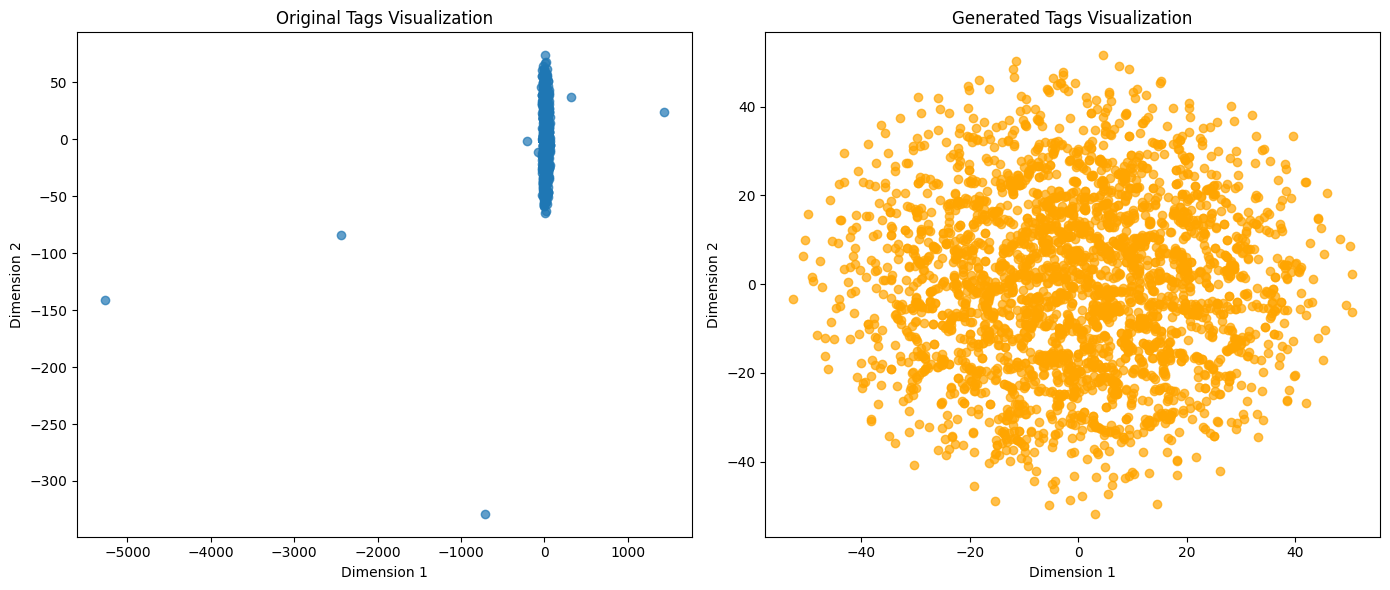

In [ ]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string
from collections import Counter
from nltk.stem import PorterStemmer

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a dictionary to hold all unique words (tags) across the dataset
unique_words = Counter()

# Populate the dictionary with token counts from the 'filtered_tokens' column
for tokens in df_items_enriched['filtered_tokens']:
    unique_words.update(tokens)

# Display the first few rows of the DataFrame including 'tags'
print(df_items_enriched[['itemId', 'title', 'genres', 'tag', 'generated_tags', 'enriched_description']].head())

# Print a summary of the unique words (vocabulary size and a sample of words)
print(f"\nTotal unique words (nouns and adjectives only): {len(unique_words)}")
print(f"Most common words: {unique_words.most_common(10)}")

# Save the dictionary of unique words
unique_words_dict = dict(unique_words)

# Prepare the data for visualization

# Function to create a multi-hot encoding matrix for tags
def create_tag_matrix(tag_lists, tag_set):
    tag_list_series = tag_lists.apply(lambda tags: [tag.lower() for tag in tags])
    matrix = np.zeros((len(tag_list_series), len(tag_set)), dtype=int)
    tag_to_index = {tag: idx for idx, tag in enumerate(tag_set)}
    for i, tags in enumerate(tag_list_series):
        for tag in tags:
            if tag in tag_to_index:
                matrix[i, tag_to_index[tag]] = 1
    return matrix

# Get the set of all tags
original_tag_set = set(tag for tags in df_items_enriched['tag'] for tag in tags)
generated_tag_set = set(tag for tags in df_items_enriched['generated_tags'] for tag in tags)

# Create multi-hot encoding matrices
original_tag_matrix = create_tag_matrix(df_items_enriched['tag'], original_tag_set)
generated_tag_matrix = create_tag_matrix(df_items_enriched['generated_tags'], generated_tag_set)

# Apply t-SNE to reduce dimensions with lower perplexity and adjust learning rate
tsne = TSNE(n_components=3, perplexity=3, learning_rate=100, random_state=42)

original_tag_embeddings = tsne.fit_transform(original_tag_matrix)
generated_tag_embeddings = tsne.fit_transform(generated_tag_matrix)

# Plotting the visualizations side by side with added transparency
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Original Tags Visualization
axs[0].scatter(original_tag_embeddings[:, 0], original_tag_embeddings[:, 1], alpha=0.7)
axs[0].set_title('Original Tags Visualization')
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')

# Generated Tags Visualization
axs[1].scatter(generated_tag_embeddings[:, 0], generated_tag_embeddings[:, 1], alpha=0.7, color='orange')
axs[1].set_title('Generated Tags Visualization')
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()
